In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: No module named 'xgboost'

In [2]:
!nvidia-smi

Sat Nov 15 06:50:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:

!pip install xgboost==2.0.3


In [4]:
df=pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [5]:
df.shape

(593994, 13)

In [6]:
df.dtypes

id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back          float64
dtype: object

In [7]:
df.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [8]:
df=df.drop_duplicates()
df.shape

(593994, 13)

In [9]:
df.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442235,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


In [10]:
num_columns=df.select_dtypes(exclude=[object]).columns
cate_columns=df.select_dtypes(include=[object]).columns

In [11]:
df[num_columns].skew()

id                      8.753559e-17
annual_income           1.719509e+00
debt_to_income_ratio    1.406680e+00
credit_score           -1.669929e-01
loan_amount             2.073598e-01
interest_rate           4.994531e-02
loan_paid_back         -1.490812e+00
dtype: float64

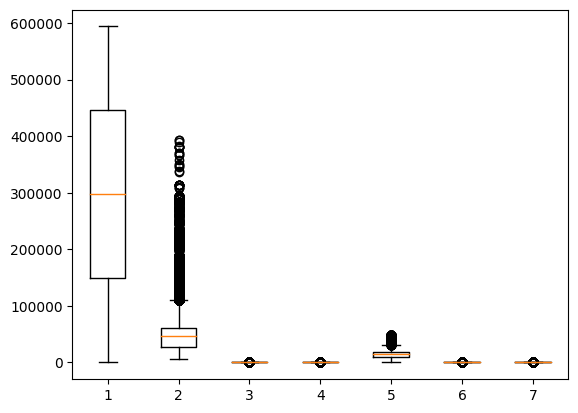

In [12]:
plt.boxplot(df[num_columns])
plt.show()

In [13]:
df['annual_income']=np.log1p(df['annual_income'])
df['debt_to_income_ratio']=np.log1p(df['debt_to_income_ratio'])
df['loan_amount']=np.log1p(df['loan_amount'])

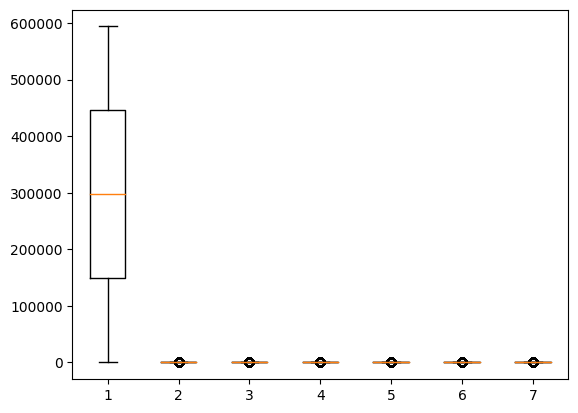

In [14]:
plt.boxplot(df[num_columns])
plt.show()

In [15]:
for i in cate_columns:
    print(df[i].unique())

['Female' 'Male' 'Other']
['Single' 'Married' 'Divorced' 'Widowed']
['High School' "Master's" "Bachelor's" 'PhD' 'Other']
['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


In [16]:
df['grade']=df['grade_subgrade'].apply(lambda x: x[0])
df['subgrade']=df['grade_subgrade'].apply(lambda x:int(x[1]))

In [17]:
df=df.drop(columns=["grade_subgrade"])

In [18]:
df.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'loan_paid_back', 'grade', 'subgrade'],
      dtype='object')

In [2]:
X=df.drop(columns=['id','loan_paid_back'])
y=df['loan_paid_back']

NameError: name 'df' is not defined

In [20]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [22]:
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num  = scaler.transform(X_test[numeric_cols])

In [23]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train_cat = ohe.fit_transform(X_train[categorical_cols])
X_test_cat  = ohe.transform(X_test[categorical_cols])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
X_train_final = np.hstack((X_train_num, X_train_cat))
X_test_final  = np.hstack((X_test_num, X_test_cat))

In [25]:
from lightgbm import LGBMClassifier

from scipy.stats import randint, uniform
params_xgb = {
    "n_estimators": randint(300, 900),
    "learning_rate": uniform(0.01, 0.15),
    "max_depth": randint(3, 12),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 4),
    "reg_lambda": uniform(0, 5),
    "min_child_weight": randint(1, 10)
}

model_xgb = XGBClassifier(
    eval_metric='logloss',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    use_label_encoder=False
)


# =====================================================
# 2. LIGHTGBM PARAMS
# =====================================================
params_lgb = {
    "num_leaves": randint(20, 80),
    "learning_rate": uniform(0.01, 0.1),
    "max_depth": randint(3, 12),
    "feature_fraction": uniform(0.6, 0.4),
    "bagging_fraction": uniform(0.6, 0.4),
    "bagging_freq": randint(1, 5),
    "n_estimators": randint(200, 800)
}

model_lgb = LGBMClassifier(
    device='gpu',
    boosting_type='gbdt',
    objective='binary',
    verbose=-1
)


# =====================================================
# 3. RANDOMIZED SEARCH FOR XGBOOST
# =====================================================
print("\n🔍 Tuning XGBoost (GPU)...")

search_xgb = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=params_xgb,
    n_iter=20,
    scoring="accuracy",
    cv=2,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search_xgb.fit(X_train_final, y_train)
best_xgb = search_xgb.best_estimator_

print("\n🏆 Best XGBoost Params:")
print(search_xgb.best_params_)


# =====================================================
# 4. RANDOMIZED SEARCH FOR LIGHTGBM
# =====================================================
print("\n🔍 Tuning LightGBM (GPU)...")

search_lgb = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=params_lgb,
    n_iter=20,
    scoring="accuracy",
    cv=2,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search_lgb.fit(X_train_final, y_train)
best_lgb = search_lgb.best_estimator_

print("\n🏆 Best LightGBM Params:")
print(search_lgb.best_params_)


# =====================================================
# 5. STACKING CLASSIFIER
# =====================================================
print("\n🤖 Building Stacking Model...\n")

stack = StackingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('lgb', best_lgb),
    ],
    final_estimator=LogisticRegression(max_iter=2000),
    n_jobs=-1,
    cv=2,
    passthrough=False
)

stack.fit(X_train_final, y_train)



🔍 Tuning XGBoost (GPU)...
Fitting 2 folds for each of 20 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:50:31] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:50:31] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:50:31] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [06:50:31] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, U


🏆 Best XGBoost Params:
{'colsample_bytree': 0.8123620356542087, 'gamma': 3.8028572256396647, 'learning_rate': 0.11979909127171076, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 421, 'reg_lambda': 0.7799726016810132, 'subsample': 0.7174250836504598}

🔍 Tuning LightGBM (GPU)...
Fitting 2 folds for each of 20 candidates, totalling 40 fits


11 warning generated warning.
 generated.
11 warning warning generated generated.
.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
11 warning generated.
 warning gen


🏆 Best LightGBM Params:
{'bagging_fraction': 0.7483273008793065, 'bagging_freq': 2, 'feature_fraction': 0.7300733288106989, 'learning_rate': 0.0829606178338064, 'max_depth': 10, 'n_estimators': 746, 'num_leaves': 20}

🤖 Building Stacking Model...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:02:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:02:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:02:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[07:02:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU 

[CV] END colsample_bytree=0.8123620356542087, gamma=3.8028572256396647, learning_rate=0.11979909127171076, max_depth=7, min_child_weight=7, n_estimators=421, reg_lambda=0.7799726016810132, subsample=0.7174250836504598; total time=   7.6s
[CV] END colsample_bytree=0.7545474901621302, gamma=0.7336180394137353, learning_rate=0.05563633644393066, max_depth=8, min_child_weight=9, n_estimators=860, reg_lambda=2.6238733012919457, subsample=0.8199582915145766; total time=  18.9s
[CV] END colsample_bytree=0.7047898756660642, gamma=0.923575302488596, learning_rate=0.04615381990390176, max_depth=9, min_child_weight=8, n_estimators=334, reg_lambda=4.546602010393911, subsample=0.777633994480005; total time=   9.4s
[CV] END colsample_bytree=0.9818496824692566, gamma=3.5793094017105953, learning_rate=0.09968499682166276, max_depth=10, min_child_weight=7, n_estimators=551, reg_lambda=0.22613644455269033, subsample=0.7975990992289792; total time=   7.2s
[CV] END colsample_bytree=0.9960660809801551, gam

StackingClassifier(cv=2,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8123620356542087,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              gamma=3.8028572256396647,
                                              gpu_id=0, grow_policy=None,
                                              importance_t...
                                              n_estimators=421, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgb',
                                LGBMClassifier(bagging_fraction=0.7483273008793065,
                                               bagging_freq=2, device='gpu',
                                               feature_fraction=0.7300733288106989,
                                               learning_rate=0.0829606178338064,
                                               max_depth=10, n_estimators=746,
                                               num_leaves=20,
                                               objective='binary',
                                               verbose=-1))],
                   final_estimator=LogisticRegression(max_iter=2000),
                   n_jobs=-1)

In [26]:
y_pred = stack.predict(X_test_final)
print("train_accuracy : ",accuracy_score(y_train,stack.predict(X_train_final)))
print("test_accuracy:", accuracy_score(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:03:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:03:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


train_accuracy :  0.9106472079882996
test_accuracy: 0.9058577934157694
